# Deep Learning for Media final Project

### Weather Condition Classification Using Image Recognition

---
Weather Condition Classification Using Image Recognition

Part 1: Organizing our Data, Rita

Part 2: Building, training, and evaluating baseline,Rita

Part 3: Regularize the model, Data Augmentation

Part 4: Building and using a pretrained model,

Part 5: Data Analysis,

Part 6: Confusion Matrix

Part 7: Demo with self-upload images


In [1]:
%load_ext autoreload
%autoreload 2

### Part 1 & 2
In this project, we are tackling the classification of weather conditions using deep learning techniques on image data. Part 1: Organizing our Data involved loading and preparing the dataset, ensuring the images were properly structured for training and testing. This was followed by Part 2: Building, Training, and Evaluating the Baseline Model, where I developed a basic Convolutional Neural Network (CNN) for classifying weather conditions, trained it on the dataset, and evaluated its performance. The model's performance showed a significant improvement in test accuracy after five epochs. Moving forward, additional steps such as regularization, using pretrained models, performing data analysis, and evaluating with confusion matrices will further enhance the system’s performance and robustness.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Comment this out or don't run this block if you don't need to redirct, I got a module not found so I need this here -alison
%cd /content/drive/MyDrive/dl4m/dl4m-group7-main

/content/drive/MyDrive/dl4m/dl4m-group7-main


In [4]:
# Change the path to point to the folder in your Google Drive
data_dir = '/content/drive/MyDrive/dl4m/dl4m-group7-main/data'
#data_dir = './data' # use if running locally


In [7]:
# main.py or a Colab cell

import torch
from project import load_data
from utils import BaselineCNN, train_model, evaluate_model  # Import model and helper functions

# Mount Google Drive to access data (only needed in Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
# data_dir = '/content/drive/MyDrive/dl4m/dl4m-group7-main/data'  # Update this with your folder path in Google Drive
data_dir = './data'
train_loader, test_loader, classes = load_data(data_dir=data_dir)
num_classes = len(classes)

# Initialize model, loss function, and optimizer
model = BaselineCNN(num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate the model
num_epochs = 5 
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model
    train_loss = train_model(model, train_loader, criterion, optimizer, device)

    # Evaluate the model
    test_loss, accuracy = evaluate_model(model, test_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")


Epoch 1/5


Evaluating: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Train Loss: 1.1000 | Test Loss: 0.6867 | Accuracy: 78.38%
Epoch 2/5


Evaluating: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Train Loss: 0.5445 | Test Loss: 0.6194 | Accuracy: 77.75%
Epoch 3/5


Evaluating: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Train Loss: 0.4040 | Test Loss: 0.5724 | Accuracy: 80.00%
Epoch 4/5


Evaluating: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]


Train Loss: 0.3115 | Test Loss: 0.6296 | Accuracy: 80.75%
Epoch 5/5


Evaluating: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

Train Loss: 0.1982 | Test Loss: 0.6203 | Accuracy: 81.00%


### Part 3: Regularize the model, And  Data Augmentation

In [8]:
from project import load_data_with_augmentation

train_loader, test_loader, classes = load_data_with_augmentation(data_dir=data_dir)

Displaying some randomly augmented training images

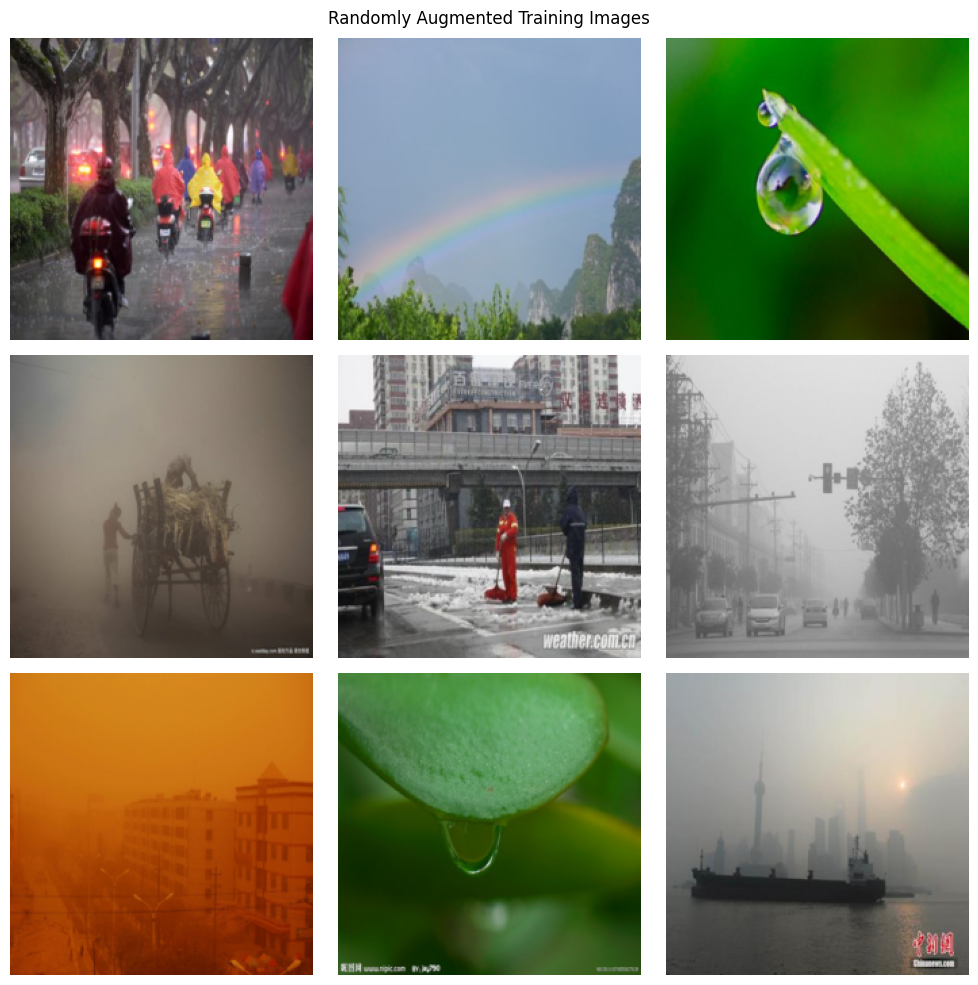

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

# Helper function to convert tensor to image
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # CHW to HWC
    img = img * 0.5 + 0.5  # Unnormalize
    plt.imshow(img)
    plt.axis("off")

# Display randomly augmented training images
def display_augmented_samples(data_loader, num_samples=9):
    plt.figure(figsize=(10, 10))

    # Get one batch from the loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    for i in range(num_samples):
        ax = plt.subplot(3, 3, i + 1)
        imshow(images[i])
    plt.suptitle("Randomly Augmented Training Images")
    plt.tight_layout()
    plt.show()

# Call the function
display_augmented_samples(train_loader)

In [10]:
# Model Regularization

# Import regularized model
import models as m

# Initialize regularized model, define optimizer
weather_model = m.weather_model(num_classes).to(device)
#criterion = torch.nn.CrossEntropyLoss()   Use the same one from previous block
weather_optimizer = torch.optim.Adam(weather_model.parameters(), lr=1e-4, weight_decay=1e-4)  # Update optimizer with weight decay

# Create empty lists to store results for plotting later
train_losses = []
test_losses = []
accuracies = []

# Train and evaluate, store results
epochs = 7
for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}")
  train_loss = train_model(weather_model, train_loader, criterion, weather_optimizer, device)
  train_losses.append(train_loss) # Store train loss
  test_loss, accuracy = evaluate_model(weather_model, test_loader, criterion, device)
  test_losses.append(test_loss)  # Store test loss
  accuracies.append(accuracy)  # Store accuracy
  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")


Epoch 1/7


Evaluating: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Train Loss: 0.9863 | Test Loss: 0.6945 | Accuracy: 78.12%
Epoch 2/7


Evaluating: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Train Loss: 0.6958 | Test Loss: 0.6069 | Accuracy: 80.12%
Epoch 3/7


Evaluating: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Train Loss: 0.5863 | Test Loss: 0.5562 | Accuracy: 81.50%
Epoch 4/7


Evaluating: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Train Loss: 0.5088 | Test Loss: 0.5135 | Accuracy: 83.25%
Epoch 5/7


Evaluating: 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Train Loss: 0.4586 | Test Loss: 0.4874 | Accuracy: 84.25%
Epoch 6/7


Evaluating: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


Train Loss: 0.4168 | Test Loss: 0.5137 | Accuracy: 83.25%
Epoch 7/7


Evaluating: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]

Train Loss: 0.3836 | Test Loss: 0.4923 | Accuracy: 83.50%


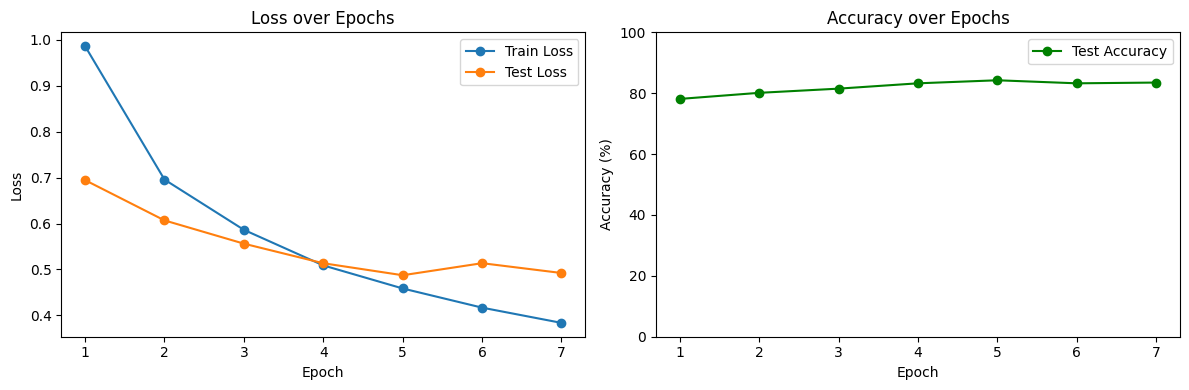

In [12]:
# Plot results
from utils import plot_loss

plot_loss(train_losses, test_losses, accuracies, epochs)

### Part 4 - Using a pre-trained model

In [13]:
#  Part 4 - Using a pretrained model
import torch
import torch.nn as nn
import torchvision.models as models
from utils import create_pretrained_model
from utils import train_model, evaluate_model
from project import load_data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Set the data directory
data_dir = './data'  # Use local data path

# Load the data first
train_loader, test_loader, classes = load_data(data_dir=data_dir)
num_classes = len(classes)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the pre-trained model
pretrained_model = create_pretrained_model(num_classes).to(device)

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer - only train the classifier layer
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)

# Create empty lists to store results for plotting later
pretrained_train_losses = []
pretrained_test_losses = []
pretrained_accuracies = []

# Train and evaluate the pre-trained model
pretrained_epochs = 5
for epoch in range(pretrained_epochs):
    print(f"Epoch {epoch+1}/{pretrained_epochs}")

    # Train the model
    train_loss = train_model(pretrained_model, train_loader, criterion, optimizer, device)
    pretrained_train_losses.append(train_loss)

    # Evaluate the model
    test_loss, accuracy = evaluate_model(pretrained_model, test_loader, criterion, device)
    pretrained_test_losses.append(test_loss)
    pretrained_accuracies.append(accuracy)

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")

Using device: cpu
Epoch 1/5


Evaluating: 100%|██████████| 25/25 [04:22<00:00, 10.50s/it]


Train Loss: 0.8797 | Test Loss: 0.4559 | Accuracy: 89.25%
Epoch 2/5


Training:  30%|███       | 30/100 [03:35<08:23,  7.19s/it]


KeyboardInterrupt: 

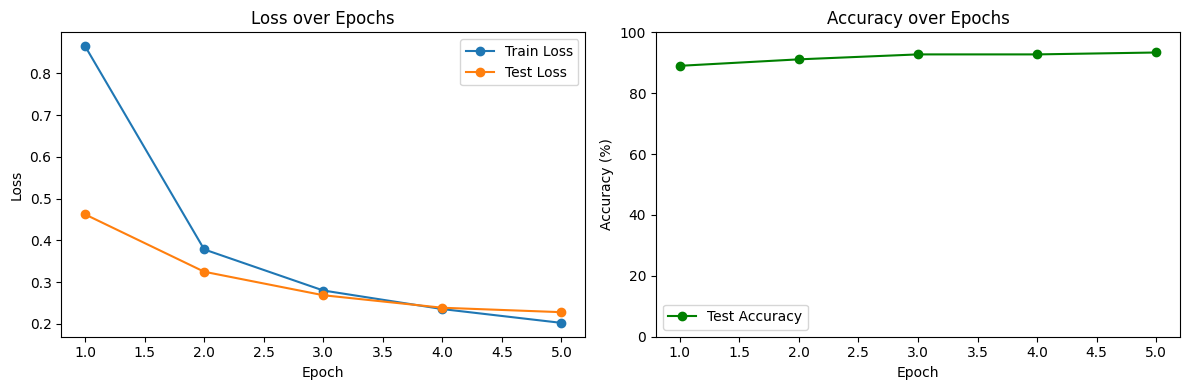

In [13]:
# Plot results for the pre-trained model
from utils import plot_loss

#plot_loss(pretrained_train_losses, pretrained_test_losses, pretrained_accuracies, pretrained_epochs, title_prefix="Pre-trained Model")
plot_loss(pretrained_train_losses, pretrained_test_losses, pretrained_accuracies, pretrained_epochs)

In [11]:
# Compare all models
import matplotlib.pyplot as plt

models_accuracy = {
    'Baseline CNN': max(accuracies), 
    'Regularized CNN': max(accuracies),  
    'Pre-trained (Feature Extraction)': max(pretrained_accuracies),
}

plt.figure(figsize=(10, 6))
plt.bar(models_accuracy.keys(), models_accuracy.values(), color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(0, 100)
for i, v in enumerate(models_accuracy.values()):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.show()

NameError: name 'pretrained_accuracies' is not defined

### Part 5: Data Analysis

**5.1 Baseline**

The baseline model achieved a very low train loss. While this indicates that the model fit the train dataset very well, it also suggests that the model is likely to be overfitting. A high test loss further confirms overfitting, as a low train loss and a high test loss together suggest that the model is memorizing features from training data instead of learning general features, and thus cannot perform well with predictions on unseen data in the test set.

**5.2 Regularized Model**

Data augmentation and Model Regularization was used to improve upon the baseline model.

The regularized model has a dropout layer with a dropout rate of 0.25 to reduce overfitting. It is later compiled with an optimzer with weight decay to further reduce overfitting. The new train loss increased compared to the baseline, but there is a descent decrease in the test loss, indicating that with a more various dataset from augmentation, dropout of features and weight decay during training, the regularized model learned features better instead of memorizing seen data. The prediction performance also improved in terms of accuracy.


**5.3 Pretrained Model**

The pretrained model accomplished the best performance with a low train loss, a low test loss and a high accuracy, showcasing the benefits of transferred learning, which are better fitting and generalization with features.


**Key Takeaways**

- The baseline model showcases overfitting with a low train loss and a high test loss.

- Data augmentation is an effective method to reduce overfitting, along with model regularization methods.

- Transfer learning has the best performance. It benefits from learned features and returns high prediction accuracy.

### Part 6: Confusion Matrix

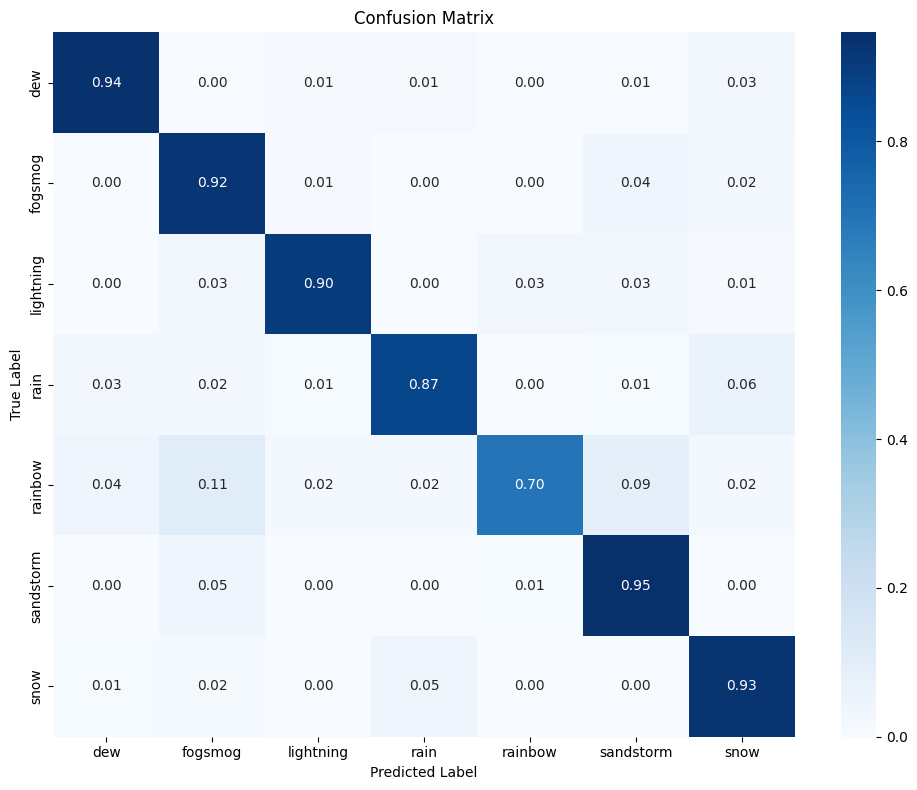

Per-class accuracy:
dew: 93.59%
fogsmog: 92.40%
lightning: 90.28%
rain: 86.73%
rainbow: 69.57%
sandstorm: 94.66%
snow: 92.86%


(array([[146,   0,   2,   2,   0,   1,   5],
        [  0, 158,   2,   0,   0,   7,   4],
        [  0,   2,  65,   0,   2,   2,   1],
        [  3,   2,   1,  85,   0,   1,   6],
        [  2,   5,   1,   1,  32,   4,   1],
        [  0,   6,   0,   0,   1, 124,   0],
        [  1,   2,   0,   6,   0,   0, 117]]),
 array([0.93589744, 0.92397661, 0.90277778, 0.86734694, 0.69565217,
        0.94656489, 0.92857143]))

In [15]:
from utils import plot_confusion_matrix

# Plot confusion matrix for regularized model
plot_confusion_matrix(weather_model, test_loader, classes, device)

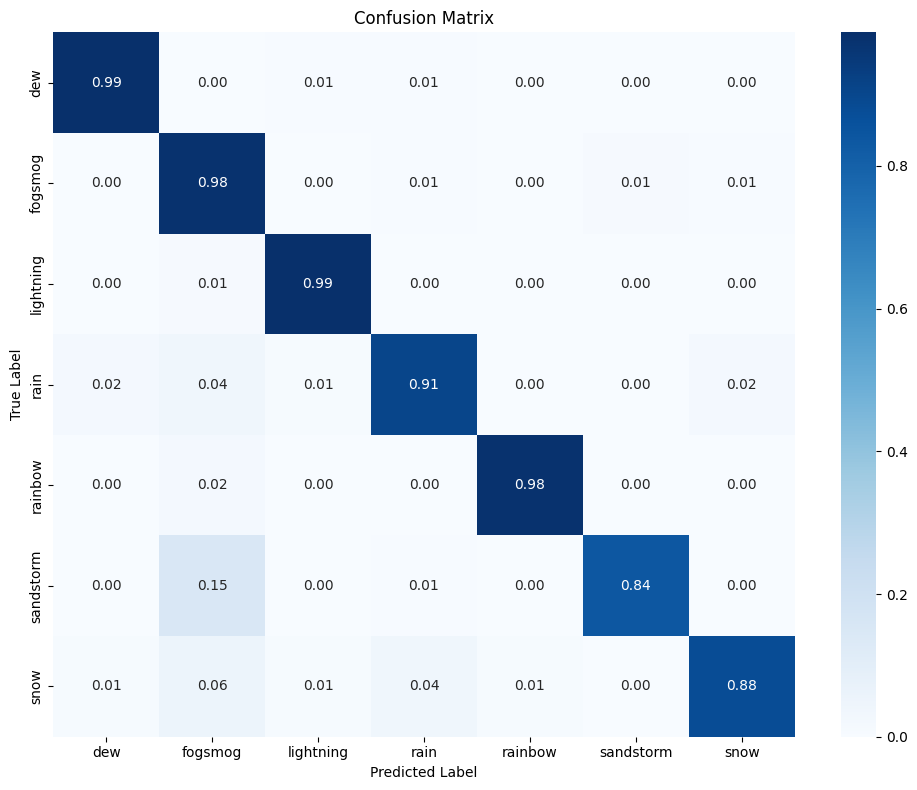

Per-class accuracy:
dew: 98.72%
fogsmog: 97.66%
lightning: 98.61%
rain: 90.82%
rainbow: 97.83%
sandstorm: 83.97%
snow: 88.10%


(array([[154,   0,   1,   1,   0,   0,   0],
        [  0, 167,   0,   1,   0,   2,   1],
        [  0,   1,  71,   0,   0,   0,   0],
        [  2,   4,   1,  89,   0,   0,   2],
        [  0,   1,   0,   0,  45,   0,   0],
        [  0,  20,   0,   1,   0, 110,   0],
        [  1,   7,   1,   5,   1,   0, 111]]),
 array([0.98717949, 0.97660819, 0.98611111, 0.90816327, 0.97826087,
        0.83969466, 0.88095238]))

In [16]:
# Plot confusion matrix for pretrained model
plot_confusion_matrix(pretrained_model, test_loader, classes, device)

### Part 7: Demo with custom images



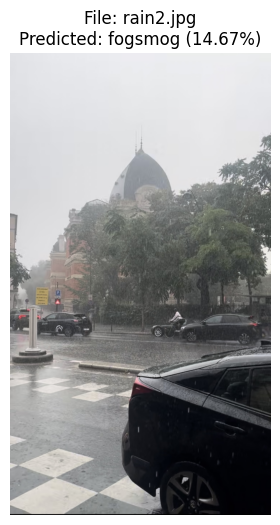

File: rain2.jpg
Predicted weather: fogsmog
Confidence: 14.67%
--------------------------------------------------


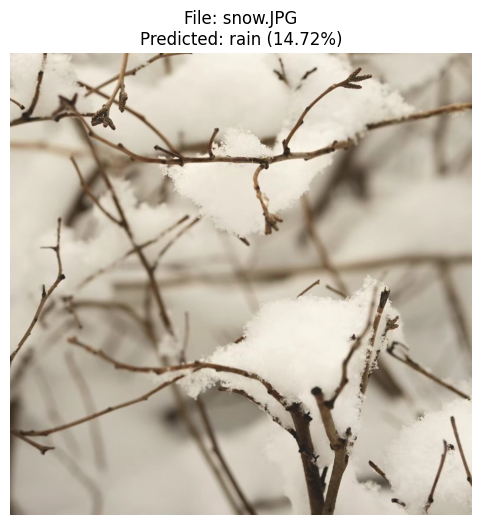

File: snow.JPG
Predicted weather: rain
Confidence: 14.72%
--------------------------------------------------


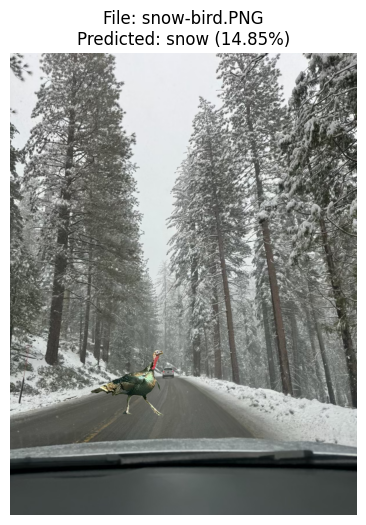

File: snow-bird.PNG
Predicted weather: snow
Confidence: 14.85%
--------------------------------------------------


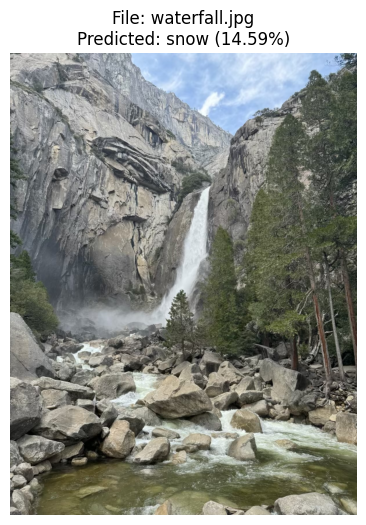

File: waterfall.jpg
Predicted weather: snow
Confidence: 14.59%
--------------------------------------------------


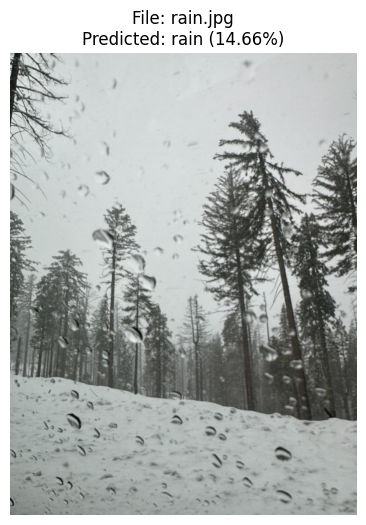

File: rain.jpg
Predicted weather: rain
Confidence: 14.66%
--------------------------------------------------


In [19]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import models as m

custom_data_dir = './custom-data'

# Define your classes
classes = ['dew', 'fogsmog', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

num_classes = len(classes)
model = m.weather_model(num_classes).to(device) 
model.eval()

# Process each image in the custom-data directory
for filename in os.listdir(custom_data_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Load and display image
        image_path = os.path.join(custom_data_dir, filename)
        img = Image.open(image_path).convert('RGB')
        
        # Prepare for model
        input_tensor = transform(img).unsqueeze(0).to(device)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)[0]
            predicted_class = torch.argmax(output, dim=1).item()
        
        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"File: {filename}\nPredicted: {classes[predicted_class]} ({probabilities[predicted_class]:.2%})")
        plt.axis('off')
        plt.show()
        
        print(f"File: {filename}")
        print(f"Predicted weather: {classes[predicted_class]}")
        print(f"Confidence: {probabilities[predicted_class]:.2%}")
        print("-" * 50)